# 下载数据集

数据集来自 http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/

我们下载的是**EnglishFnt.tgz**，是印刷体数字加大小写字母。

* [tqdm](https://github.com/tqdm/tqdm) 是一个进度条的库。
* [requests](http://docs.python-requests.org/en/master/) 是一个对人类友好的 HTTP 库。

In [1]:
import requests
from tqdm import tqdm
import os

fileurl = 'http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishFnt.tgz'
filename = 'EnglishFnt.tgz'
if not os.path.exists(filename):
    r = requests.get(fileurl, stream=True)
    with open(filename, 'wb') as f:
        for chunk in tqdm(r.iter_content(1024), unit='KB', total=int(r.headers['Content-Length'])/1024): 
            f.write(chunk)

48651KB [01:38, 492.01KB/s]                           


# 解压数据集

* [tarfile](https://docs.python.org/2/library/tarfile.html) 是 Python 自带的操作 tar 文件的库。
* [shutil](https://docs.python.org/2/library/shutil.html) 是 Python 自带的高级文件操作库。


In [2]:
import tarfile
import shutil

def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def rmdir(path):
    if os.path.exists(path):
        shutil.rmtree(path)

with tarfile.open(filename, 'r') as tfile:
    print 'loading'
    members = tfile.getmembers()
    for member in tqdm(members):
        if tarfile.TarInfo.isdir(member):
            mkdir(member.name)
            continue
        with open(member.name, 'wb') as f:
            f.write(tfile.extractfile(member).read())

loading


100%|██████████| 63055/63055 [00:11<00:00, 5350.48it/s]


# 分类数据集

数据集有数字和大小写字母，但是我们只需要0123456789和非数字。

因此将 A~Z,a~z 的图片移到 A 的文件夹，再将其他空文件夹删除。

In [3]:
notnumdir = 'English/Fnt/Sample011/'
for i in tqdm(range(12, 63)):
    path = 'English/Fnt/Sample%03d/' % i
    for filename in os.listdir(path):
        os.rename(path+filename, notnumdir+filename)
    os.rmdir(path)

100%|██████████| 51/51 [00:03<00:00, 12.79it/s]


# 预处理数据集

我们需要将这里的图片裁切为28*28，以便于输入到神经网络中。

## 首先测试一张图

In [4]:
import cv2
import numpy as np

def resize(rawimg):  # resize img to 28*28
    fx = 28.0 / rawimg.shape[0]
    fy = 28.0 / rawimg.shape[1]
    fx = fy = min(fx, fy)
    img = cv2.resize(rawimg, None, fx=fx, fy=fy, interpolation=cv2.INTER_CUBIC)
    outimg = np.ones((28, 28), dtype=np.uint8) * 255
    w = img.shape[1]
    h = img.shape[0]
    x = (28 - w) / 2
    y = (28 - h) / 2
    outimg[y:y+h, x:x+w] = img
    return outimg

def convert(imgpath):
    img = cv2.imread(imgpath)
    gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
    bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 25, 25)
    img2, ctrs, hier = cv2.findContours(bw.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    x, y, w, h = rects[-1]
    roi = gray[y:y+h, x:x+w]
    return resize(roi)

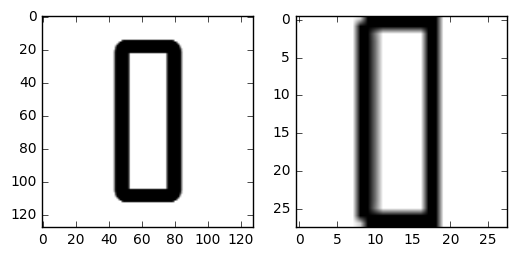

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

imgpath = 'English/Fnt/Sample001/img001-00001.png'
img = cv2.imread(imgpath)
rsz = convert(imgpath)

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(rsz, cmap='gray')

## 预处理所有图片

In [6]:
rmdir('train')

for i in range(11):
    path = 'English/Fnt/Sample%03d/' % (i+1)
    trainpath = 'train/%d/' % i
    mkdir(trainpath)
    for filename in tqdm(os.listdir(path), desc=trainpath):
        try:
            cv2.imwrite(trainpath + filename, convert(path + filename))
        except:
            pass

train/10/: 100%|██████████| 52832/52832 [00:52<00:00, 999.49it/s] 


# 分离出验证数据集

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [11]:
from sklearn.model_selection import train_test_split
for i in range(11):
    trainpath = 'train/%d/' % i
    validpath = 'valid/%d/' % i
    mkdir(validpath)
    imgs = os.listdir(trainpath)
    trainimgs, validimgs = train_test_split(imgs, test_size=0.1)
    for filename in validimgs:
        os.rename(trainpath+filename, validpath+filename)